# Predicting the Winning Football Team

Can we design a predictive model capable of accurately predicting if the home team will win a football match? 


## Steps

1. We will clean our dataset
2. Split it into training and testing data (12 features & 1 target (winning team (Home/Away/Draw))
3. Train 3 different classifiers on the data 
  -Logistic Regression
  -Support Vector Machine 
  -XGBoost
4. Use the best Classifer to predict who will win given an away team and a home team

## History

Sports betting is a 500 billion dollar market (Sydney Herald)

![alt text](https://static1.squarespace.com/static/506a95bbc4aa0491a951c141/t/51a55d97e4b00f4428967e64/1369791896526/sports-620x349.jpg "Logo Title Text 1")

Kaggle hosts a yearly competiton called March Madness 

https://www.kaggle.com/c/march-machine-learning-mania-2017/kernels

Several Papers on this 

https://arxiv.org/pdf/1511.05837.pdf

"It is possible to predict the winner of English county twenty twenty cricket games in almost two thirds of instances."

https://arxiv.org/pdf/1411.1243.pdf

"Something that becomes clear from the results is that Twitter contains enough information to be useful for
predicting outcomes in the Premier League"

https://qz.com/233830/world-cup-germany-argentina-predictions-microsoft/

For the 2014 World Cup, Bing correctly predicted the outcomes for all of the 15 games in the knockout round.

So the right questions to ask are

-What model should we use?
-What are the features (the aspects of a game) that matter the most to predicting a team win? Does being the home team give a team the advantage? 

## Dataset

- Football is played by 250 million players in over 200 countries (most popular sport globally)
- The English Premier League is the most popular domestic team in the world
- Retrived dataset from http://football-data.co.uk/data.php

![alt text](http://i.imgur.com/YRIctyo.png "Logo Title Text 1")

- Football is a team sport, a cheering crowd helps morale
- Familarity with pitch and weather conditions helps
- No need to travel (less fatigue)


## Import Dependencies

In [1]:
#data preprocessing
import pandas as pd
#produces a prediction model in the form of an ensemble of weak prediction models, typically decision tree
import xgboost as xgb
#the outcome (dependent variable) has only a limited number of possible values. 
#Logistic Regression is used when response variable is categorical in nature.
from sklearn.linear_model import LogisticRegression
#A random forest is a meta estimator that fits a number of decision tree classifiers 
#on various sub-samples of the dataset and use averaging to improve the predictive 
#accuracy and control over-fitting.
from sklearn.ensemble import RandomForestClassifier
#a discriminative classifier formally defined by a separating hyperplane.
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
#displayd data
from IPython.display import display
import matplotlib.pyplot as plt

import numpy as np
# import seaborn as sns
import sqlite3
import matplotlib.gridspec as gridspec
from numpy import random
import scipy.stats as scipy

# from sklearn.metrics import accuracy_score
%matplotlib inline

In [2]:
# Read data and drop redundant column.
data = pd.read_csv('Datasets/final_dataset_edited.csv')

# Preview data.
display(data.head())


#Full Time Result (H=Home Win, D=Draw, A=Away Win)
#HTGD - Home team goal difference
#ATGD - away team goal difference
#HTP - Home team points
#ATP - Away team points
#DiffFormPts Diff in points
#DiffLP - Differnece in last years prediction

#Input - 12 other features (fouls, shots, goals, misses,corners, red card, yellow cards)
#Output - Full Time Result (H=Home Win, D=Draw, A=Away Win)

#Ignore the Deprication warnings in the code
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


,Unnamed: 0,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTGS,ATGS,HTGC,...,HTLossStreak5,ATWinStreak3,ATWinStreak5,ATLossStreak3,ATLossStreak5,HTGD,ATGD,DiffPts,DiffFormPts,DiffLP
0,0,2000-08-19,Charlton,Man City,4,0,H,0,0,0,...,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0
1,1,2000-08-19,Chelsea,West Ham,4,2,H,0,0,0,...,0,0,0,0,0,0.0,0.0,0.0,0.0,-4.0
2,2,2000-08-19,Coventry,Middlesbrough,1,3,NH,0,0,0,...,0,0,0,0,0,0.0,0.0,0.0,0.0,2.0
3,3,2000-08-19,Derby,Southampton,2,2,NH,0,0,0,...,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0
4,4,2000-08-19,Leeds,Everton,2,0,H,0,0,0,...,0,0,0,0,0,0.0,0.0,0.0,0.0,-10.0


In [39]:
#loading all leagues data from sqlite DB
with sqlite3.connect('datasets/database.sqlite') as con:
    countries = pd.read_sql_query("SELECT * from Country", con)
    matches = pd.read_sql_query("SELECT * from Match", con)
    leagues = pd.read_sql_query("SELECT * from League", con)
    teams = pd.read_sql_query("SELECT * from Team", con)
    tempmatch = pd.read_sql_query("SELECT * from Match", con)

In [40]:
#Subsetting the five countries of interest
main_countries = ['England','France','Germany','Italy','Spain']
countries = countries[countries.name.isin(main_countries)]
leagues = countries.merge(leagues,on='id',suffixes=('', '_y'))
seasons = matches.season.unique()
leagues

,id,name,country_id,name_y
0,1729,England,1729,England Premier League
1,4769,France,4769,France Ligue 1
2,7809,Germany,7809,Germany 1. Bundesliga
3,10257,Italy,10257,Italy Serie A
4,21518,Spain,21518,Spain LIGA BBVA


In [41]:
def res(row):
    if row['home_team_goal'] == row['away_team_goal']:
        val = 0
    elif row['home_team_goal'] > row['away_team_goal']:
        val = 1
    else:
        val = -1
    return val

In [42]:
#Merge the leagues with corresponding matches
req_matches = matches[matches.league_id.isin(leagues['id'])]
req_matches = req_matches[['id','league_id','home_team_api_id','away_team_api_id','home_team_goal','away_team_goal','season']]
req_matches["total_goals"] = req_matches['home_team_goal'] + req_matches['away_team_goal']
req_matches["result"] = req_matches.apply(res,axis = 1)
req_matches.dropna(inplace=True)
req_matches.head()

,id,league_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,season,total_goals,result
1728,1729,1729,10260,10261,1,1,2008/2009,2,0
1729,1730,1729,9825,8659,1,0,2008/2009,1,1
1730,1731,1729,8472,8650,0,1,2008/2009,1,-1
1731,1732,1729,8654,8528,2,1,2008/2009,3,1
1732,1733,1729,10252,8456,4,2,2008/2009,6,1


In [43]:
#Separating the leagues for plotting and further analysis
new_matches = pd.merge(req_matches,leagues,left_on='league_id', right_on='id')
new_matches = new_matches.drop(['id_x','id_y','country_id'],axis = 1)
english = new_matches[new_matches.name == "England"]
french = new_matches[new_matches.name == "France"]
italian = new_matches[new_matches.name == "Italy"]
spanish = new_matches[new_matches.name == "Spain"]
german = new_matches[new_matches.name == "Germany"]
# sum_goals = new_group_matches.home_team_goal.sum()
e = english.groupby('season')
f = french.groupby('season')
i = italian.groupby('season')
s = spanish.groupby('season')
g = german.groupby('season')
seasons

array(['2008/2009', '2009/2010', '2010/2011', '2011/2012', '2012/2013',
       '2013/2014', '2014/2015', '2015/2016'], dtype=object)

### How many goals does league score every season?

We start by investigating the trends in number of goals scored each season across leagues.

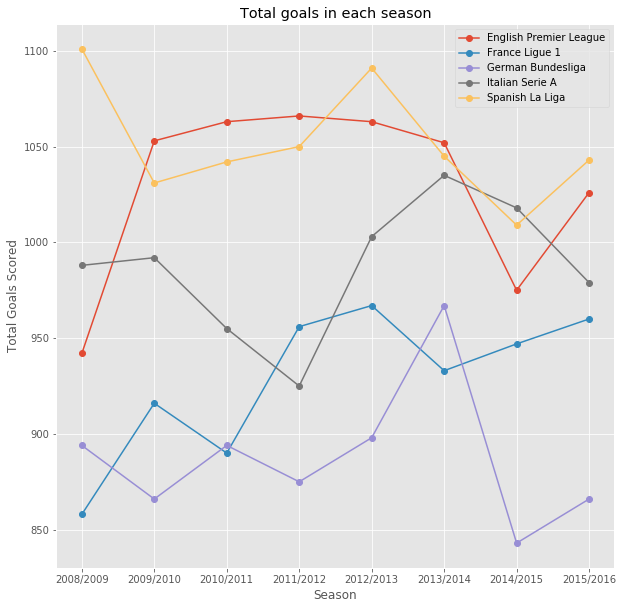

In [44]:
#Plotting total goals scored each season
fig = plt.figure(figsize=(10, 10))
plt.title("Total goals in each season")
plt.xticks(range(len(seasons)),seasons)
plt.style.use('ggplot')
plt.xlabel("Season")
plt.ylabel("Total Goals Scored")
num_seasons = range(len(seasons))
plt.plot(num_seasons,e.total_goals.sum().values,label = "English Premier League", marker = 'o')
plt.plot(num_seasons,f.total_goals.sum().values,label = "France Ligue 1", marker = 'o')
plt.plot(num_seasons,g.total_goals.sum().values,label = "German Bundesliga", marker = 'o')
plt.plot(num_seasons,i.total_goals.sum().values,label = "Italian Serie A", marker = 'o')
plt.plot(num_seasons,s.total_goals.sum().values,label = "Spanish La Liga", marker = 'o')
plt.legend()

The Spanish La Liga teams resort to much more aggressive tactics and formations every game as compared to the other leagues' teams. This, I believe, translates directly to more goals being scored than in other leagues.

Also, even though it might look like the Bundesliga teams scored fewer goals each season, it is to be remember that they play fewer games compared to teams from other leagues. In Bundesliga, there are only 18 teams playing each season and hence, they play a total of 306 games. In contrast, the other leagues have 20 teams and hence end up playing 380 games.

Therefore, it would be a good idea to look at the average number of goals scored each game by season.

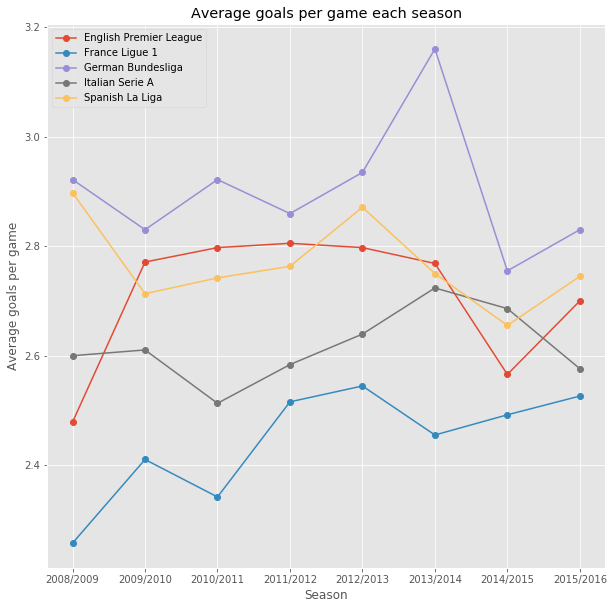

In [45]:
#Plotting average goals scored each season
fig = plt.figure(figsize=(10, 10))
plt.xticks(range(len(seasons)),seasons)
plt.style.use('ggplot')
plt.xlabel("Season")
plt.title("Average goals per game each season")
plt.ylabel("Average goals per game")
plt.plot(num_seasons,e.total_goals.mean().values,label = "English Premier League", marker = 'o')
plt.plot(num_seasons,f.total_goals.mean().values,label = "France Ligue 1", marker = 'o')
plt.plot(num_seasons,g.total_goals.mean().values,label = "German Bundesliga", marker = 'o')
plt.plot(num_seasons,i.total_goals.mean().values,label = "Italian Serie A", marker = 'o')
plt.plot(num_seasons,s.total_goals.mean().values,label = "Spanish La Liga", marker = 'o')
#plt.xlim = (-20,20)
plt.legend(loc = 2)

The Bundesliga teams score way more on average in each game that the teams in other leagues. In the 2013/2014 season, Bundesliga teams scored more than 3 goals each game on an average (967 goals in 306 matches - 3.16 per match). And teams in Ligue 1 have scored the least number of goals on a per game basis. 

### Investigating home team advantage?
There is always the conspicuous home team advantage in every sport but does it truly exist? Do teams really end up scoring more goals at their home stadium than when playing at an away fixture?

Let's try plotting number of goals scored at home (vs away) and subsequently the number of home wins. 

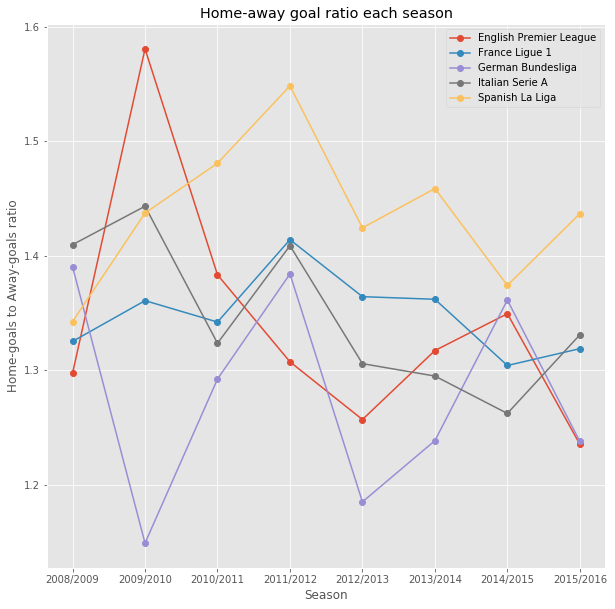

In [10]:
#Plotting home/away scored each season
fig = plt.figure(figsize=(10, 10))
plt.xticks(range(len(seasons)),seasons)
plt.style.use('ggplot')
plt.title('Home-away goal ratio each season')
plt.xlabel('Season')
plt.ylabel('Home-goals to Away-goals ratio')
plt.plot(num_seasons,e.home_team_goal.mean().values / e.away_team_goal.mean().values,label = "English Premier League", marker = 'o')
plt.plot(num_seasons,f.home_team_goal.mean().values / f.away_team_goal.mean().values,label = "France Ligue 1", marker = 'o')
plt.plot(num_seasons,g.home_team_goal.mean().values / g.away_team_goal.mean().values,label = "German Bundesliga", marker = 'o')
plt.plot(num_seasons,i.home_team_goal.mean().values / i.away_team_goal.mean().values,label = "Italian Serie A", marker = 'o')
plt.plot(num_seasons,s.home_team_goal.mean().values / s.away_team_goal.mean().values,label = "Spanish La Liga", marker = 'o')
#plt.xlim = (-20,20),
plt.legend(loc = 1)


In the last five seasons, La Liga teams have had a strong home advantage. This could be a key factor when they host teams from other leagues for European Leagues like the UEFA Championship or the Europa League. In such championship matches, there are usually two fixtures played (home and away) by each team. And since goals scored in each of these fixtures plays a role in teams qualifying to the next round, there seems to a big advantage to the La Liga teams in recent seasons.

The ratios for other leagues seem to vary significantly and not show any significant trends except the Bundesliga, again, which keeps oscillating between a strong home game and weak home game season. 

All the (home-goals/away-goals) ratios are above 1 and we can consistently see the ratio being above 1.3 for most leagues. This only shows that, on an average, teams score more at home fixtures than away. But how many of these matches do they win?

Again, since Bundesliga teams play 74 fewer games than the other league teams, let's plot the home-away win ratio for each league every season.

In [11]:
#Subsetting homewins vs homeloss from each of the leagues - ignoring draws.
e_hw = np.true_divide(english[english.result == 1].groupby('season').result.sum().values,english[english.result == -1].groupby('season').result.sum().values * -1)
f_hw = np.true_divide(french[french.result == 1].groupby('season').result.sum().values,french[french.result == -1].groupby('season').result.sum().values *-1)
g_hw = np.true_divide(german[german.result == 1].groupby('season').result.sum().values,german[german.result == -1].groupby('season').result.sum().values*-1)
i_hw = np.true_divide(italian[italian.result == 1].groupby('season').result.sum().values,italian[italian.result == -1].groupby('season').result.sum().values*-1)
s_hw = np.true_divide(spanish[spanish.result == 1].groupby('season').result.sum().values,spanish[spanish.result == -1].groupby('season').result.sum().values*-1)

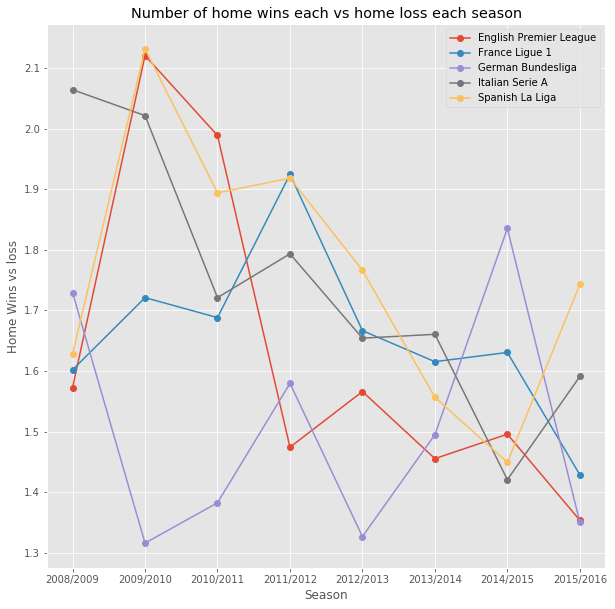

In [12]:
#Plotting number of home wins vs home losses each season
fig = plt.figure(figsize=(10, 10))
plt.xticks(range(len(seasons)),seasons)
plt.style.use('ggplot')
plt.xlim = (-20,20)
plt.ylim = (0,120)
plt.title("Number of home wins each vs home loss each season")
plt.xlabel("Season")
plt.ylabel("Home Wins vs loss")
plt.plot(num_seasons,e_hw,label = "English Premier League", marker = 'o')
plt.plot(num_seasons,f_hw,label = "France Ligue 1", marker = 'o')
plt.plot(num_seasons,g_hw,label = "German Bundesliga", marker = 'o')
plt.plot(num_seasons,i_hw,label = "Italian Serie A", marker = 'o')
plt.plot(num_seasons,s_hw,label = "Spanish La Liga", marker = 'o')
plt.legend(loc = 1)


We can see that a few leagues are winning fewer matches at home recently. In particular, there seems to be a steady decreasing trend in the French Ligue and the English Premier League. However, we are plotting only the home wins against the home losses and not taking draws into consideration. 

We could analyse the home-goals analysis for each team in the lague and also compare the ratio of number of home wins to home losses. In doing so, we could choose one of two things :
1. Include draw as a loss for the home team
2. Include draw as a win for the home team

In [13]:
def autolabel(rects):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2.0, 1*height,
                '%d' % int(height),
                ha='center', va='bottom')

In [14]:
#New dataframe merging home_team names and matches.
matches_w_teams = pd.merge(new_matches,teams,left_on='home_team_api_id', right_on='team_api_id')
matches_w_teams = matches_w_teams.drop(['id','team_api_id','team_fifa_api_id'],axis = 1)
matches_w_teams = matches_w_teams.rename(columns={'team_long_name':'home_team_long_name','name_y':'league_name','name':'country_name'})
matches_w_teams.head(1)

,league_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,season,total_goals,result,country_name,league_name,home_team_long_name,team_short_name
0,1729,10260,10261,1,1,2008/2009,2,0,England,England Premier League,Manchester United,MUN


In [15]:
#Color scheme for each country - from colourbrewer2.org
import matplotlib.patches as mpatches
colors = {'England':'#e41a1c', 'Spain':'#377eb8', 'Italy':'#4daf4a', 'France':'#984ea3', 'Germany':'#ff7f00'}
color = []

e = mpatches.Patch(color='#e41a1c', label='England')
s = mpatches.Patch(color='#377eb8', label='Spain')
it = mpatches.Patch(color='#4daf4a', label='Italy') #Facepalm note to self : never use i as it'll be used as an iterable for a for loop
f = mpatches.Patch(color='#984ea3', label='France')
g = mpatches.Patch(color='#ff7f00', label='Germany')


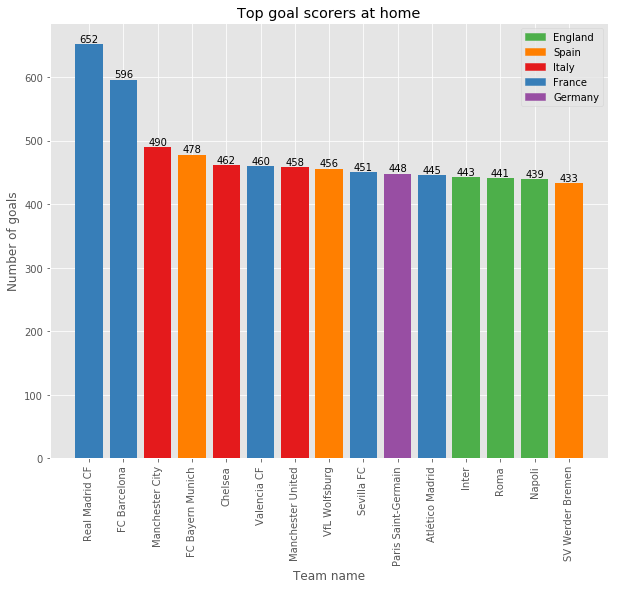

In [16]:
#Analysing teams in each league
top_n = 15
top_goal_scorers = matches_w_teams.groupby('home_team_long_name').total_goals.sum().sort_values(ascending = False)

for i in range(top_n):
    color.append([colors[t] for t in matches_w_teams[matches_w_teams.home_team_long_name == top_goal_scorers.head(top_n).index[i]].country_name.values][0])

fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(1,1,1)
rects = ax.bar(range(top_n), top_goal_scorers.head(top_n).values,align = "center",color = color)

ax.set_xticks(range(top_n))
ax.set_xticklabels(top_goal_scorers.head(top_n).index,rotation = "vertical")
ax.set_title("Top goal scorers at home")
ax.set_ylabel("Number of goals")
ax.set_xlabel("Team name")

ax.legend([it,g,e,s,f], colors.keys())
autolabel(rects)


Again, we see the dominance by the two big Spanish teams (Real Madrid and Barcelona) in scoring goals at home. The next competitor, Manchester City(490) is nearly a 100 goals behind FC Barcelona(596). And Real Madrid(652) leads the race ahead of its nearest competitor (and fierce rival), FC Barcelona, by 56 goals. 

Apart from this, we also notice that 5 of the top 15 teams are from Spain. England, Italy, Germany have three teams each and France has just the one big-spending club, Paris Saint-Germain in the top 15. 

It would be interesting to also look at the ratio of home wins to home losses for teams and compare it with this graph.

In [17]:
#We get teams' home win vs home loss ratio
team_home_win = matches_w_teams[matches_w_teams.result == 1].groupby('home_team_long_name').result.sum().sort_index()
team_home_loss = matches_w_teams[matches_w_teams.result ==  -1].groupby('home_team_long_name').count().result.sort_index()
team_home_draw_loss = matches_w_teams[matches_w_teams.result !=  1].groupby('home_team_long_name').count().result.sort_index()
team_home_draw_win =  matches_w_teams[matches_w_teams.result !=  -1].groupby('home_team_long_name').count().result.sort_index()
np.setdiff1d(team_home_loss.index,team_home_win.index)

#We notice that a team "SpVgg Greuther Furth" never won a home game in the one season it played in Germany. Remove it.
team_home_loss = team_home_loss[team_home_loss.index.str.contains("SpV") == False]
team_home_draw_win = team_home_draw_win[team_home_draw_win.index.str.contains("SpV") == False]

team_home_wl_ratio = team_home_win /team_home_loss
team_home_wl_ratio = team_home_wl_ratio.sort_values(ascending = False)
#print team_home_wl_ratio.head()

team_home_wld_ratio = team_home_win / team_home_draw_loss
team_home_wld_ratio = team_home_wld_ratio.sort_values(ascending = False)
#team_home_wld_ratio.head()

team_home_wdl_ratio = team_home_draw_win / team_home_loss
team_home_wdl_ratio = team_home_wdl_ratio.sort_values(ascending = False)


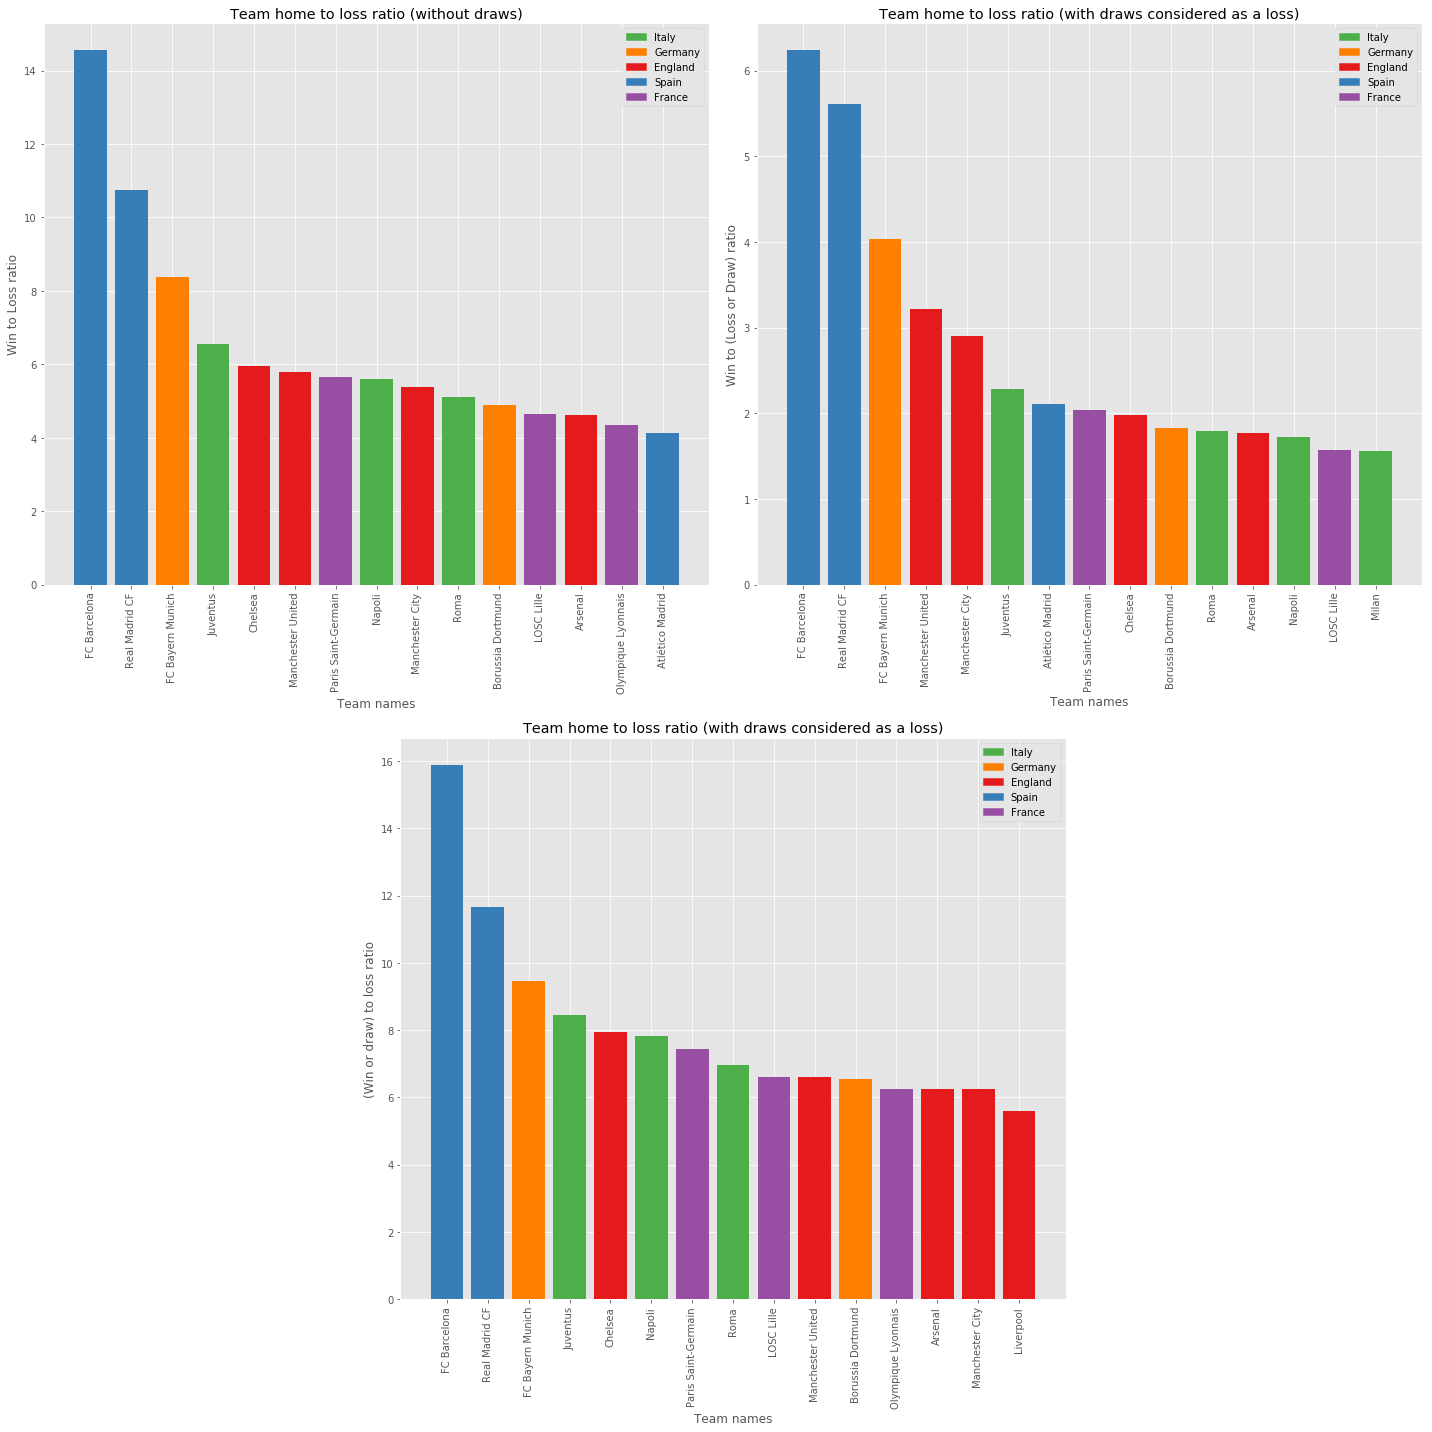

In [18]:
#Plotting top_n ratios
fig = plt.figure(figsize = (20,20))
plt.style.use('ggplot')

colorwl = []
colorwld = []
colorwdl = []
for i in range(top_n):
    colorwl.append([colors[t] for t in matches_w_teams[matches_w_teams.home_team_long_name == team_home_wl_ratio.head(top_n).index[i]].country_name.values][0])
    colorwld.append([colors[t] for t in matches_w_teams[matches_w_teams.home_team_long_name == team_home_wld_ratio.head(top_n).index[i]].country_name.values][0])
    colorwdl.append([colors[t] for t in matches_w_teams[matches_w_teams.home_team_long_name == team_home_wdl_ratio.head(top_n).index[i]].country_name.values][0])

gs = gridspec.GridSpec(2, 4)
ax1 = fig.add_subplot(gs[0, :2],)
rects1 = ax1.bar(range(top_n), team_home_wl_ratio.head(top_n).values,align = "center", color = colorwl)
ax1.set_xticks(range(top_n))
ax1.set_xticklabels(team_home_wl_ratio.head(top_n).index,rotation = "vertical")
ax1.set_title("Team home to loss ratio (without draws)")
ax1.set_ylabel("Win to Loss ratio")
ax1.set_xlabel("Team names")
ax1.legend([it,g,e,s,f], ["Italy","Germany","England","Spain","France"])

ax2 = fig.add_subplot(gs[0, 2:])
rects2 = ax2.bar(range(top_n), team_home_wld_ratio.head(top_n).values,align = "center", color = colorwld)
ax2.set_xticks(range(top_n))
ax2.set_xticklabels(team_home_wld_ratio.head(top_n).index,rotation = "vertical")
ax2.set_title("Team home to loss ratio (with draws considered as a loss)")
ax2.set_ylabel("Win to (Loss or Draw) ratio")
ax2.set_xlabel("Team names")
ax2.legend([it,g,e,s,f], ["Italy","Germany","England","Spain","France"])

ax3 = fig.add_subplot(gs[1,1:3])
rects3 = ax3.bar(range(top_n), team_home_wdl_ratio.head(top_n).values,align = "center", color = colorwdl)
ax3.set_xticks(range(top_n))
ax3.set_xticklabels(team_home_wdl_ratio.head(top_n).index,rotation = "vertical")
ax3.set_title("Team home to loss ratio (with draws considered as a loss)")
ax3.set_ylabel("(Win or draw) to loss ratio")
ax3.set_xlabel("Team names")
ax3.legend([it,g,e,s,f], ["Italy","Germany","England","Spain","France"])
plt.tight_layout()

Keeping with the trends, the two giants enjoy a considerably large (11 to 14) home win to loss ratio. Even if we consider draws, FC Barcelona and Real Madrid win at least 5 times more games at home than lose or draw. Following these two is FC Bayern Munich (from Germany) which also wins 4 times more than lose or draw at home.

Other big teams in the top 15 also have significantly large (4+) home win to loss ratio. However, the home win to (loss or draw) ratio is slightly lower (1.5 to 4) for these teams. Also, we can see that if we carried out the analyses by considering a draw to the number of wins list as opposed to the loss list, we get a much higher ratio (FC Barcelona nearly equal to 16).

These factors indicate that the top teams enjoy a very high home advantage. We could probably look at trends in each season and check how select teams are performing on this home-advantage factor.

We should also analyse how other teams at the bottom of the table perform on these factors. 

## Predictability across leagues

We know that football is a highly unpredictable game but how unpredictable is it really? Are there any differences between leagues in this regard?

From the dataset, we get the prior odds of a home win, draw and away win for each match given by Bet365, a popular betting agency. I believe that these odds captures information that cannot really be quantified; information such as a change in manager, general sentiment towards a team and its form, arrival of a new star player etc. 

By converting the odds to probabilities and calculating entropy (a measure of randomness used in information theory and in decision trees), we try to guage the randomness in the occurrence of the three results (home win, draw, away).

In [19]:
matches = matches[matches.league_id.isin(leagues.id)]
matches = matches[['id', 'country_id' ,'league_id', 'season', 'stage', 'date','match_api_id', 'home_team_api_id', 'away_team_api_id','B365H', 'B365D' ,'B365A']]
matches.dropna(inplace=True)
# matches.head()

#### Entropy function for each match

In [20]:
from scipy.stats import entropy


def match_entropy(row):
    odds = [row['B365H'],row['B365D'],row['B365A']]
    #change odds to probability
    probs = [1/o for o in odds]
    #normalize to sum to 1
    norm = sum(probs)
    probs = [p/norm for p in probs]
    return entropy(probs)

matches['entropy'] = matches.apply(match_entropy,axis=1)

#### Mean entropy for each season

In [21]:
mean_ent = matches.groupby(('season','league_id')).entropy.mean()
mean_ent = mean_ent.reset_index().pivot(index='season', columns='league_id', values='entropy')
mean_ent.columns = [leagues[leagues.id==x].name.values[0] for x in mean_ent.columns]
mean_ent.head(10)

,England,France,Germany,Italy,Spain
season,,,,,
2008/2009,0.984556,1.026638,1.004276,1.002201,1.010859
2009/2010,0.956496,1.013821,0.997925,1.006755,0.977810
2010/2011,0.983258,1.026236,1.016264,1.006029,0.975032
2011/2012,0.969593,1.024915,1.001298,1.003077,0.955339
2012/2013,0.981472,1.016116,0.993993,1.003565,0.970580
2013/2014,0.960473,1.004439,0.977500,0.992622,0.944218
2014/2015,0.980301,1.012495,0.985835,0.999100,0.933637
2015/2016,0.997819,1.013928,0.974657,0.985284,0.946813


Text(7.3,0.952,'more predictable')

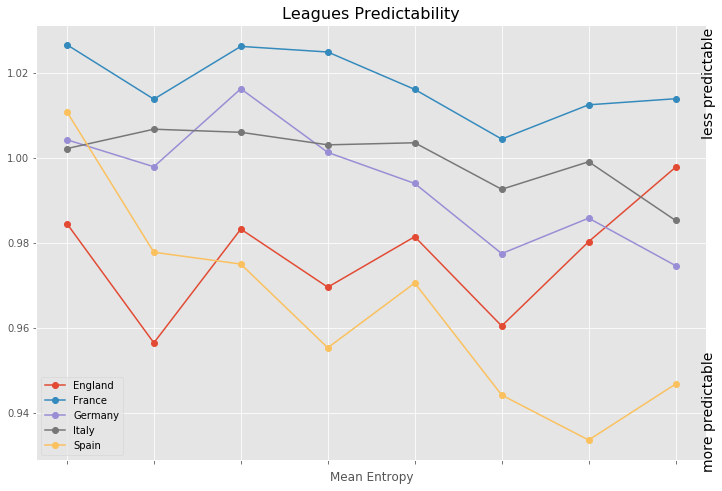

In [22]:
ax = mean_ent.plot(figsize=(12,8),marker='o')
plt.title('Leagues Predictability', fontsize=16)
plt.xticks(rotation=50)

colors = [x.get_color() for x in ax.get_lines()]
colors_mapping = dict(zip(leagues.id,colors))

ax.set_xlabel('Mean Entropy')
plt.legend(loc='lower left')

ax.annotate('less predictable', xy=(7.3, 1.028), annotation_clip=False,fontsize=14,rotation='vertical')
ax.annotate('more predictable', xy=(7.3, 0.952), annotation_clip=False,fontsize=14,rotation='vertical')


This graph shows that the Spanish league is very predictable as compared to the other leauges. This is expected because since the 1950s, two teams (Barcelona and Real Madrid) have dominated the league winning 55 times among them. 

On the other hand, the English Premier League has become less predictable in recent times (Leicester City winning the title!) and previously dominant teams(Manchester United, Liverpool) losing their strength. 

#### Teamwise Analysis

In [23]:
from matplotlib.lines import Line2D


barcelona = teams[teams.team_long_name=='Barcelona'].team_api_id.values
offsets = [-0.16,-0.08,0,0.08,0.16]
offsets_mapping = dict(zip(colors_mapping.keys(),offsets))
y = []
x = []
c = []

i = -1
for season,season_df in matches.groupby('season'):
    i+=1
    for team,name in zip(teams.team_api_id,teams.team_long_name):
        team_df = season_df[(season_df.home_team_api_id==team)|(season_df.away_team_api_id==team)]
        team_entropy = team_df.entropy.mean()
        if team_entropy>0:
            league_id = team_df.league_id.values[0]
            x.append(i+offsets_mapping[league_id])
            y.append(team_entropy)
            c.append(colors_mapping[league_id])


Text(6.93,0.78,'PSG')

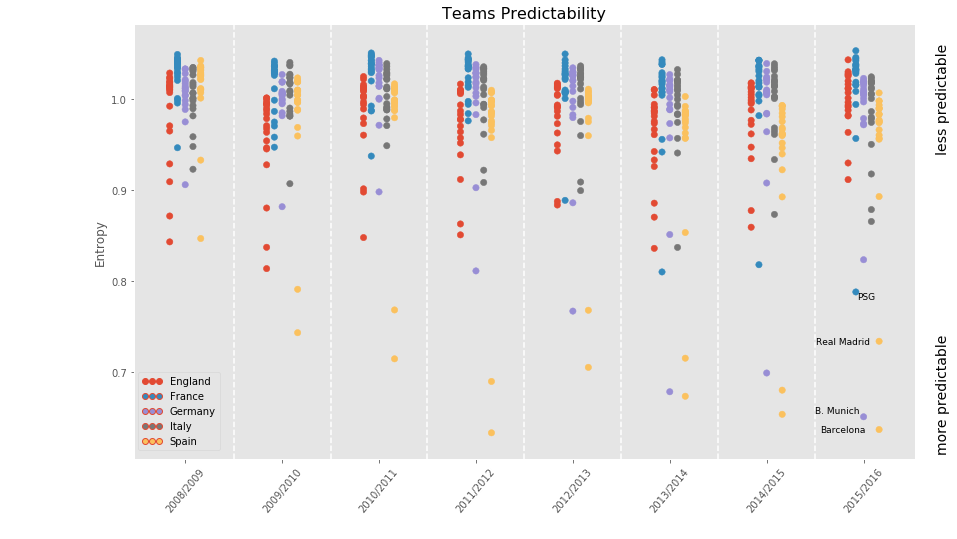

In [24]:

plt.figure(figsize=(14,8))

plt.scatter(x,y,color=c,s=[40]*len(x))
plt.title('Teams Predictability', fontsize=16)

ax = plt.gca()
plt.xlim = (-0.5,7.5)
plt.xticks(np.arange(0,8,1),rotation=50)
ax.set_ylabel("Entropy")

ax.set_xticklabels(mean_ent.index)
for i in range(7):
    ax.axvline(x=0.5+i,ls='--',c='w')
ax.yaxis.grid(False)
ax.xaxis.grid(False)

circles = []
labels = []
for league_id,name in zip(leagues.id,leagues.name):
    labels.append(name)
    circles.append(Line2D([0], [0], linestyle="none", marker="o", markersize=6, markerfacecolor=colors_mapping[league_id]))
plt.legend(circles, labels, numpoints=3, loc=(0.005,0.02))


ax.annotate('', xytext=(7.65, 0.93),xy=(7.65, 1.1), arrowprops=dict(facecolor='black',arrowstyle="->, head_length=.7, head_width=.3",linewidth=1))
ax.annotate('', xytext=(7.65, 0.77),xy=(7.65, 0.6), arrowprops=dict(facecolor='black',arrowstyle="->, head_length=.7, head_width=.3",linewidth=1))

ax.annotate('less predictable', xy=(7.75, 1.05), annotation_clip=False,fontsize=14,rotation='vertical')
ax.annotate('more predictable', xy=(7.75, 0.73), annotation_clip=False,fontsize=14,rotation='vertical')

#add labels
ax.annotate('Barcelona', xy=(6.55, 0.634),fontsize=9)
ax.annotate('B. Munich', xy=(6.5, 0.655),fontsize=9)
ax.annotate('Real Madrid', xy=(6.51, 0.731),fontsize=9)
ax.annotate('PSG', xy=(6.93, 0.78),fontsize=9)


Again, quite expectedly, Barcelona and Real Madrid are near outliers along with Bayern Munich. These teams are very predictable in the sense that they're always expected to win. PSG follow closely in the list. 

## Data Exploration

In [25]:
#what is the win rate for the home team?

# Total number of matches.
n_matches = data.shape[0]

# Calculate number of features. -1 because we are saving one as the target variable (win/lose/draw)
n_features = data.shape[1] - 1

# Calculate matches won by home team.
n_homewins = len(data[data.FTR == 'H'])

# Calculate win rate for home team.
win_rate = (float(n_homewins) / (n_matches)) * 100

# Print the results
print ("Total number of matches: {}".format(n_matches))
print ("Number of features: {}".format(n_features))
print ("Number of matches won by home team: {}".format(n_homewins))
print ("Win rate of home team: {:.2f}%".format(win_rate))

Total number of matches: 6080
Number of features: 42
Number of matches won by home team: 2816
Win rate of home team: 46.32%


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a13cc0e10>,
      dtype=object)

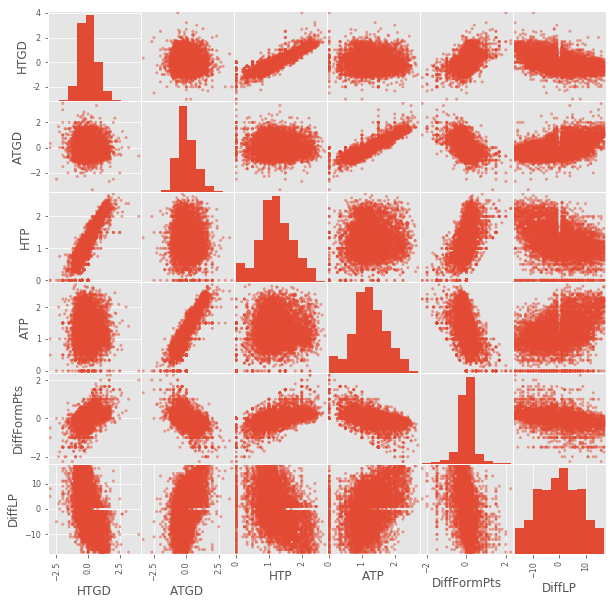

In [26]:
# Visualising distribution of data
from pandas.plotting import scatter_matrix

#the scatter matrix is plotting each of the columns specified against each other column.
#You would have observed that the diagonal graph is defined as a histogram, which means that in the 
#section of the plot matrix where the variable is against itself, a histogram is plotted.

#Scatter plots show how much one variable is affected by another. 
#The relationship between two variables is called their correlation
#negative vs positive correlation

#HTGD - Home team goal difference
#ATGD - away team goal difference
#HTP - Home team points
#ATP - Away team points
#DiffFormPts Diff in points
#DiffLP - Differnece in last years prediction

scatter_matrix(data[['HTGD','ATGD','HTP','ATP','DiffFormPts','DiffLP']], figsize=(10,10))
# display(data)

## Preparing the Data

In [27]:
# Separate into feature set and target variable
#FTR = Full Time Result (H=Home Win, D=Draw, A=Away Win)
X_all = data.drop(['FTR'],1)
y_all = data['FTR']
# display(X_all)
# display(y_all)

# Standardising the data.
from sklearn.preprocessing import scale

#Center to the mean and component wise scale to unit variance.
cols = [['HTGD','ATGD','HTP','ATP','DiffLP']]
for col in cols:
    X_all[col] = scale(X_all[col])
# print(X_all.Date.dtype)

In [28]:
print ("UN-Processed feature columns ({} total features)".format(len(X_all.columns)))
#last 3 wins for both sides
X_all.HM1 = X_all.HM1.astype('str')
X_all.HM2 = X_all.HM2.astype('str')
X_all.HM3 = X_all.HM3.astype('str')
X_all.AM1 = X_all.AM1.astype('str')
X_all.AM2 = X_all.AM2.astype('str')
X_all.AM3 = X_all.AM3.astype('str')


req_cols=['HTP','ATP','HM1','HM2','HM3','AM1','AM2','AM3','HTGD','ATGD','DiffFormPts','DiffLP']
X_all = pd.DataFrame(X_all,columns=req_cols)


#we want continous vars that are integers for our input data, so lets remove any categorical vars
def preprocess_features(X):
    ''' Preprocesses the football data and converts catagorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():
#         If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix = col)
                    
        # Collect the revised columns
        output = output.join(col_data)
    return output

X_all = preprocess_features(X_all)
drop_cols = ['HM1_M','HM2_M','HM3_M','AM1_M','AM2_M','AM3_M']
X_all = X_all.drop(drop_cols, axis=1)
# display(X_all)
print ("Processed feature columns ({} total features):\n{}".format(len(X_all.columns), list(X_all.columns)))

UN-Processed feature columns (42 total features)
Processed feature columns (24 total features):
['HTP', 'ATP', 'HM1_D', 'HM1_L', 'HM1_W', 'HM2_D', 'HM2_L', 'HM2_W', 'HM3_D', 'HM3_L', 'HM3_W', 'AM1_D', 'AM1_L', 'AM1_W', 'AM2_D', 'AM2_L', 'AM2_W', 'AM3_D', 'AM3_L', 'AM3_W', 'HTGD', 'ATGD', 'DiffFormPts', 'DiffLP']


In [29]:
# Show the feature information by printing the first five rows
print ("\nFeature values:")
display(X_all.head())


Feature values:


,HTP,ATP,HM1_D,HM1_L,HM1_W,HM2_D,HM2_L,HM2_W,HM3_D,HM3_L,...,AM2_D,AM2_L,AM2_W,AM3_D,AM3_L,AM3_W,HTGD,ATGD,DiffFormPts,DiffLP
0,-2.303259,-2.373125,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.014963,-0.022914,0.0,0.000000
1,-2.303259,-2.373125,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.014963,-0.022914,0.0,-0.496101
2,-2.303259,-2.373125,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.014963,-0.022914,0.0,0.248051
3,-2.303259,-2.373125,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.014963,-0.022914,0.0,0.124025
4,-2.303259,-2.373125,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.014963,-0.022914,0.0,-1.240253


In [30]:
from sklearn.cross_validation import train_test_split

# Shuffle and split the dataset into training and testing set.
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, 
                                                    test_size = 100,
                                                    random_state = 2,
                                                    stratify = y_all)


## Training and Evaluating Models

In [31]:
#for measuring training time
from time import time 
# F1 score (also F-score or F-measure) is a measure of a test's accuracy. 
#It considers both the precision p and the recall r of the test to compute 
#the score: p is the number of correct positive results divided by the number of 
#all positive results, and r is the number of correct positive results divided by 
#the number of positive results that should have been returned. The F1 score can be 
#interpreted as a weighted average of the precision and recall, where an F1 score 
#reaches its best value at 1 and worst at 0.
from sklearn.metrics import f1_score
from xgboost import plot_tree

def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
#     print(clf)
    end = time()
    
    # Print the results
    print ("Trained model in {:.4f} seconds".format(end - start))

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    
    end = time()
    # Print and return results
    print ("Made predictions in {:.4f} seconds.".format(end - start))
    
    return f1_score(target, y_pred, pos_label='H'), sum(target == y_pred) / float(len(y_pred))


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print ("Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train)))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    f1, acc = predict_labels(clf, X_train, y_train)
    print (f1, acc)
    print ("F1 score and accuracy score for training set: {:.4f} , {:.4f}.".format(f1 , acc))
    
    f1, acc = predict_labels(clf, X_test, y_test)
    print ("F1 score and accuracy score for test set: {:.4f} , {:.4f}.".format(f1 , acc))

Logistic Regression

![alt text](https://image.slidesharecdn.com/logisticregression-predictingthechancesofcoronaryheartdisease-091203130638-phpapp01/95/logistic-regression-predicting-the-chances-of-coronary-heart-disease-2-728.jpg?cb=1259845609"Logo Title Text 1")

![alt text](https://i.ytimg.com/vi/HdB-z0TJRK4/maxresdefault.jpg "Logo Title Text 1")

Support Vector Machine

![alt text](https://image.slidesharecdn.com/supportvectormachine-121112135318-phpapp01/95/support-vector-machine-3-638.jpg?cb=1352729591 "Logo Title Text 1")
![alt text](http://docs.opencv.org/2.4/_images/optimal-hyperplane.png "Logo Title Text 1")

XGBoost

![alt text](https://raw.githubusercontent.com/dmlc/web-data/master/xgboost/model/cart.png "Logo Title Text 1")

![alt text](https://raw.githubusercontent.com/dmlc/web-data/master/xgboost/model/twocart.png "Logo Title Text 1")

![alt text](https://image.slidesharecdn.com/0782ee51-165d-4e34-a09c-2b7f8dacff01-150403064822-conversion-gate01/95/feature-importance-analysis-with-xgboost-in-tax-audit-17-638.jpg?cb=1450092771 "Logo Title Text 1")

![alt text](https://image.slidesharecdn.com/0782ee51-165d-4e34-a09c-2b7f8dacff01-150403064822-conversion-gate01/95/feature-importance-analysis-with-xgboost-in-tax-audit-18-638.jpg?cb=1450092771 "Logo Title Text 1")

In [32]:
# Initialize the three models (XGBoost is initialized later)
clf_A = LogisticRegression(random_state = 42)
clf_B = SVC(random_state = 912, kernel = 'rbf')
#Boosting refers to this general problem of producing a very accurate prediction rule 
#by combining rough and moderately inaccurate rules-of-thumb
# clf_C = xgb.XGBClassifier(random_state = 10)
clf_C = xgb.XGBClassifier(n_estimators = 90,max_depth = 7)
clf_D = KNeighborsClassifier(n_neighbors = 10)
train_predict(clf_A, X_train, y_train, X_test, y_test)
print ('')
train_predict(clf_B, X_train, y_train, X_test, y_test)
print ('')
train_predict(clf_C, X_train, y_train, X_test, y_test)
print ('')
train_predict(clf_D, X_train, y_train, X_test, y_test)
print ('')

Training a LogisticRegression using a training set size of 5980. . .
Trained model in 0.3502 seconds
Made predictions in 0.0013 seconds.
0.6131914084774758 0.6596989966555183
F1 score and accuracy score for training set: 0.6132 , 0.6597.
Made predictions in 0.0006 seconds.
F1 score and accuracy score for test set: 0.6517 , 0.6900.

Training a SVC using a training set size of 5980. . .
Trained model in 2.1810 seconds
Made predictions in 1.2129 seconds.
0.6161475897639356 0.6764214046822743
F1 score and accuracy score for training set: 0.6161 , 0.6764.
Made predictions in 0.0193 seconds.
F1 score and accuracy score for test set: 0.6207 , 0.6700.

Training a XGBClassifier using a training set size of 5980. . .
Trained model in 1.4831 seconds
Made predictions in 0.0881 seconds.
0.8332066869300911 0.8531772575250837
F1 score and accuracy score for training set: 0.8332 , 0.8532.
Made predictions in 0.0025 seconds.
F1 score and accuracy score for test set: 0.6076 , 0.6900.

Training a KNeighb

**Clearly XGBoost seems like the best model as it has the highest F1 score and accuracy score on the test set.**

# Tuning the parameters of XGBoost.

![alt text](https://i.stack.imgur.com/9GgQK.jpg "Logo Title Text 1")

In [33]:
    # TODO: Import 'GridSearchCV' and 'make_scorer'
    from sklearn.grid_search import GridSearchCV
    from sklearn.metrics import make_scorer
    from sklearn.metrics import accuracy_score
    from sklearn.learning_curve import validation_curve

    C_param_range = [0.001,0.01,0.1,1,10,100]


    # TODO: Create the parameters list you wish to tune
    parameters = { 'learning_rate' : [0.1],
                   'n_estimators' : [40],
                   'max_depth': [3],
                   'min_child_weight': [3],
                   'gamma':[0.4],
                   'subsample' : [0.8],
                   'colsample_bytree' : [0.8],
                   'scale_pos_weight' : [1],
                   'reg_alpha':[1e-1]
                 }

    # TODO: Initialize the classifier
    clf = xgb.XGBClassifier(n_estimators = 90,max_depth = 7)

    # TODO: Make an f1 scoring function using 'make_scorer' 
    f1_scorer = make_scorer(f1_score,pos_label='H')

    # TODO: Perform grid search on the classifier using the f1_scorer as the scoring method
    grid_obj = GridSearchCV(clf,
                            scoring=f1_scorer,
                            param_grid=parameters,
                            cv=5)

    # TODO: Fit the grid search object to the training data and find the optimal parameters
    grid_obj = grid_obj.fit(X_train,y_train)

    # Get the estimator
    clf = grid_obj.best_estimator_
    print (clf)

    # Report the final F1 score for training and testing after parameter tuning
    f1, acc = predict_labels(clf, X_train, y_train)
    print ("F1 score and accuracy score for training set: {:.4f} , {:.4f}.".format(f1 , acc))

    f1, acc = predict_labels(clf, X_test, y_test)
    print ("F1 score and accuracy score for test set: {:.4f} , {:.4f}.".format(f1 , acc))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.4, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=3, missing=None,
       n_estimators=40, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0.1,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.8)
Made predictions in 0.0107 seconds.
F1 score and accuracy score for training set: 0.6249 , 0.6756.
Made predictions in 0.0015 seconds.
F1 score and accuracy score for test set: 0.5581 , 0.6200.


In [37]:
#prediction
display(X_test.head())
display(y_test.head(10))
predicted_matches = clf_C.predict(X_test)
print(predicted_matches[:10])

,HTP,ATP,HM1_D,HM1_L,HM1_W,HM2_D,HM2_L,HM2_W,HM3_D,HM3_L,...,AM2_D,AM2_L,AM2_W,AM3_D,AM3_L,AM3_W,HTGD,ATGD,DiffFormPts,DiffLP
1655,-1.213657,-0.852258,0,1,0,1,0,0,1,0,...,1,0,0,1,0,0,-1.247916,-0.550242,-0.214286,0.744152
2000,-0.223110,0.794301,0,1,0,1,0,0,0,0,...,1,0,0,0,0,1,-0.386862,0.514002,-0.181818,0.496101
3401,0.634249,0.137988,1,0,0,0,0,1,0,1,...,0,0,1,0,1,0,0.572450,-0.102726,0.054054,-0.620127
444,-0.668856,-0.713997,0,0,1,0,0,1,0,1,...,0,1,0,0,0,1,-1.458395,-1.077571,0.000000,0.496101
3173,0.148345,-0.437476,1,0,0,0,0,1,1,0,...,0,0,1,0,0,1,-0.405997,-0.444777,0.214286,-0.372076


1655     H
2000     H
3401     H
444     NH
3173    NH
3891    NH
1899     H
5029     H
5987     H
3372    NH
Name: FTR, dtype: object

['NH' 'H' 'H' 'NH' 'NH' 'NH' 'NH' 'H' 'NH' 'NH']
